# Data Science Trading Practice

1. Need to be able to clean up data - DONE
2. Need to be able to see data output in the form of a CS chart - DONE
3. Need to be able to see volume in the chart as well - DONE
4. Need to create functions for everything to make things more modular - DONE
5. Need to be able to identify certain patterns within the data
6. Need to make multiple plots visible at the same time to see if code can identify certain patterns consistently

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime

# Loading in csv file data
AAPL_1min_sample_path = '../frd_stock_sample/AAPL_1min_sample.csv'
AAPL_1min = pd.read_csv(AAPL_1min_sample_path)

# Function for converting timestamp and setting it as index
def get_true_timestamp_and_set_as_index(pd_csv_ticker_1min):
    # Converting timestamp to actual timestamp
    pd_csv_ticker_1min['timestamp'] = pd.to_datetime(pd_csv_ticker_1min['timestamp'])
    
    # Setting the index to the timestamp
    pd_csv_ticker_1min.set_index('timestamp', inplace=True)

    return pd_csv_ticker_1min

AAPL_1min = get_true_timestamp_and_set_as_index(AAPL_1min)

# Filling in missing minutes

In [87]:
# Function for filling in missing minutes

def fill_missing_minutes(index_timestamp_1_min, keep_only_PM_to_TD = False):
    index_timestamp_1_min = index_timestamp_1_min.resample('min').asfreq()

    # Filling in NaN values (volume with 0 and close to the last known close)
    index_timestamp_1_min['volume'] = index_timestamp_1_min['volume'].fillna(0);
    index_timestamp_1_min['close'] = index_timestamp_1_min['close'].ffill();
    
    # Filling in the rest, with the NaN being equal to the previous close
    index_timestamp_1_min['open'] = index_timestamp_1_min['open'].fillna(index_timestamp_1_min['close']);
    index_timestamp_1_min['high'] = index_timestamp_1_min['high'].fillna(index_timestamp_1_min['close']);
    index_timestamp_1_min['low'] = index_timestamp_1_min['low'].fillna(index_timestamp_1_min['close']);
    
    # Making sure there are only weekdays
    index_timestamp_1_min = index_timestamp_1_min[index_timestamp_1_min.index.weekday < 5]

    # Keeping only data from 4:00am to 3:59pm (if keep_only_PM_to_TD is True)
    if keep_only_PM_to_TD:
        index_timestamp_1_min = index_timestamp_1_min.between_time('4:00', '15:59')
    
    # Resetting the index to get timestamp back as a column
    index_timestamp_1_min.reset_index(inplace = True)

    return index_timestamp_1_min

AAPL_1min = fill_missing_minutes(AAPL_1min, True)

In [49]:
AAPL_1min[20:30]

,timestamp,open,high,low,close,volume
20,2024-07-15 04:20:00,233.16,233.16,233.16,233.16,263.0
21,2024-07-15 04:21:00,233.18,233.18,233.16,233.16,200.0
22,2024-07-15 04:22:00,233.16,233.18,233.16,233.18,508.0
23,2024-07-15 04:23:00,233.18,233.18,233.18,233.18,0.0
24,2024-07-15 04:24:00,233.35,233.39,233.35,233.39,200.0
25,2024-07-15 04:25:00,233.39,233.39,233.39,233.39,0.0
26,2024-07-15 04:26:00,233.38,233.38,233.37,233.37,1980.0
27,2024-07-15 04:27:00,233.35,233.39,233.35,233.39,1202.0
28,2024-07-15 04:28:00,233.38,233.38,233.38,233.38,100.0
29,2024-07-15 04:29:00,233.38,233.39,233.38,233.39,3834.0


In [50]:
print(AAPL_1min.head())

            timestamp    open    high     low   close   volume
0 2024-07-15 04:00:00  232.22  233.26  232.22  233.26  17697.0
1 2024-07-15 04:01:00  233.25  233.75  233.25  233.55   7151.0
2 2024-07-15 04:02:00  233.50  234.00  233.50  233.81   6579.0
3 2024-07-15 04:03:00  233.71  233.89  233.61  233.70   6007.0
4 2024-07-15 04:04:00  233.69  233.70  232.00  233.44   6335.0


# Getting datetime into string formats

In [52]:
# Function for separating out timestamp into date and time (and their string formats)
def separate_dt(full_1min):
    full_1min['date'] = full_1min['timestamp'].dt.date
    full_1min['date_str'] = full_1min['date'].astype(str)
    full_1min['time'] = full_1min['timestamp'].dt.time
    full_1min['time_str'] = full_1min['time'].astype(str).str.slice(0, 5)

    return full_1min
    
# Function for cutting off any values that are not within total trading time (including pre- and post- market hours)
def cutoff_irrelevant_hours(with_separate_dt_1min):
    Trading_day_start_w_pre = pd.to_datetime('04:00:00').time()
    Trading_day_end_w_post = pd.to_datetime('19:59:00').time()
    with_separate_dt_1min = with_separate_dt_1min[
        (with_separate_dt_1min['time'] >= Trading_day_start_w_pre) & 
        (with_separate_dt_1min['time'] <= Trading_day_end_w_post)
    ].reset_index()

    return with_separate_dt_1min

AAPL_1min = separate_dt(AAPL_1min)
AAPL_1min = cutoff_irrelevant_hours(AAPL_1min)

# Getting PM daily highs and lows

In [54]:
# Function for getting PM daily highs and lows
def get_daily_PM_HL(true_1min):
    # Getting only the times in the PM
    PM_end = pd.to_datetime('09:30:00').time()
    PM_start = pd.to_datetime('04:00:00').time()
    
    # PM Data
    true_1min = true_1min[(true_1min["time"] >= PM_start) & (true_1min["time"] < PM_end)]
    
    # Grouping by 'date' and calculating the PM high and low for each day
    Daily_PM_HL = true_1min.groupby('date').agg(
        PM_high = ('high', 'max'),
        PM_low = ('low', 'min')
    )

    return Daily_PM_HL

Daily_PM_HL = get_daily_PM_HL(AAPL_1min)

# Using Matplotlib (by CoderzColumn)

In [56]:
# Function for getting full 1_min data to just one chosen date
def full_1min_one_date(full_1min, date_str):
    Chosen_date = date_str
    Chosen_dt = pd.to_datetime(Chosen_date).date()

    # Getting the data to be just of that chosen date
    full_1min_1_date = full_1min[(full_1min['date'] == Chosen_dt)]

    return full_1min_1_date

# Function for limiting the data a bit to more easily analyze it
def limit_times(full_1min_1_date, starting_minutes, ending_minutes):
    full_1min_S = full_1min_1_date[starting_minutes:ending_minutes].reset_index()

    return full_1min_S # "Full 1 minute small"

Chosen_date = '2024-07-19'
AAPL_1min_1_date = full_1min_one_date(AAPL_1min, Chosen_date)
AAPL_S = limit_times(AAPL_1min_1_date, 300, 480)

In [57]:
# Function for getting green CS:
def get_green_CS(full_1min_S):
    green_CS = full_1min_S[full_1min_S['open'] <= full_1min_S['close']].copy()
    green_CS['Height'] = green_CS['close'] - green_CS['open']
    green_CS['Height'] = green_CS['Height'].apply(lambda x: 0.005 if x == 0 else x) # Setting to 0.005 just so we can see SOMETHING when height is 0
    
    return green_CS

# Function for getting red CS:
def get_red_CS(full_1min_S):
    red_CS = full_1min_S[full_1min_S['open'] > full_1min_S['close']].copy()
    red_CS['Height'] = red_CS['open'] - red_CS['close'] # Don't need to set height to 0.005 b/c height is never 0 for red CS (see above row)

    return red_CS

green_CS = get_green_CS(AAPL_S)
red_CS = get_red_CS(AAPL_S)

In [58]:
green_CS[0:20]

,level_0,index,timestamp,open,high,low,close,volume,date,date_str,time,time_str,Height
0,3180,3180,2024-07-19 09:00:00,226.3000,226.3923,226.3000,226.3923,2195.0,2024-07-19,2024-07-19,09:00:00,09:00,0.0923
3,3183,3183,2024-07-19 09:03:00,225.9200,225.9500,225.8800,225.9500,2131.0,2024-07-19,2024-07-19,09:03:00,09:03,0.0300
5,3185,3185,2024-07-19 09:05:00,225.8800,225.9800,225.8800,225.9800,8700.0,2024-07-19,2024-07-19,09:05:00,09:05,0.1000
9,3189,3189,2024-07-19 09:09:00,225.7200,225.9500,225.7200,225.9500,1941.0,2024-07-19,2024-07-19,09:09:00,09:09,0.2300
10,3190,3190,2024-07-19 09:10:00,225.9500,225.9500,225.9500,225.9500,0.0,2024-07-19,2024-07-19,09:10:00,09:10,0.0050
11,3191,3191,2024-07-19 09:11:00,226.0000,226.0500,226.0000,226.0500,1606.0,2024-07-19,2024-07-19,09:11:00,09:11,0.0500
13,3193,3193,2024-07-19 09:13:00,226.0500,226.0700,226.0200,226.0700,1581.0,2024-07-19,2024-07-19,09:13:00,09:13,0.0200
14,3194,3194,2024-07-19 09:14:00,226.0600,226.0700,226.0600,226.0700,561.0,2024-07-19,2024-07-19,09:14:00,09:14,0.0100
15,3195,3195,2024-07-19 09:15:00,225.9500,225.9800,225.9300,225.9800,1055.0,2024-07-19,2024-07-19,09:15:00,09:15,0.0300
17,3197,3197,2024-07-19 09:17:00,225.8300,225.8500,225.8300,225.8500,637.0,2024-07-19,2024-07-19,09:17:00,09:17,0.0200


In [59]:
red_CS[::]

,level_0,index,timestamp,open,high,low,close,volume,date,date_str,time,time_str,Height
1,3181,3181,2024-07-19 09:01:00,226.3100,226.3100,226.210,226.2100,1798.0,2024-07-19,2024-07-19,09:01:00,09:01,0.1000
2,3182,3182,2024-07-19 09:02:00,226.2100,226.2100,225.880,225.8800,6671.0,2024-07-19,2024-07-19,09:02:00,09:02,0.3300
4,3184,3184,2024-07-19 09:04:00,225.9800,225.9800,225.900,225.9000,1500.0,2024-07-19,2024-07-19,09:04:00,09:04,0.0800
6,3186,3186,2024-07-19 09:06:00,225.9200,226.0000,225.900,225.9000,528.0,2024-07-19,2024-07-19,09:06:00,09:06,0.0200
7,3187,3187,2024-07-19 09:07:00,226.0486,226.0486,225.980,225.9800,400.0,2024-07-19,2024-07-19,09:07:00,09:07,0.0686
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,3350,3350,2024-07-19 11:50:00,224.3100,224.3250,224.175,224.2150,35011.0,2024-07-19,2024-07-19,11:50:00,11:50,0.0950
172,3352,3352,2024-07-19 11:52:00,224.4400,224.4400,224.310,224.3265,28753.0,2024-07-19,2024-07-19,11:52:00,11:52,0.1135
173,3353,3353,2024-07-19 11:53:00,224.3200,224.3700,224.230,224.3100,43326.0,2024-07-19,2024-07-19,11:53:00,11:53,0.0100
175,3355,3355,2024-07-19 11:55:00,224.4727,224.5200,224.370,224.4200,68077.0,2024-07-19,2024-07-19,11:55:00,11:55,0.0527


# Getting both CS and volume graphs

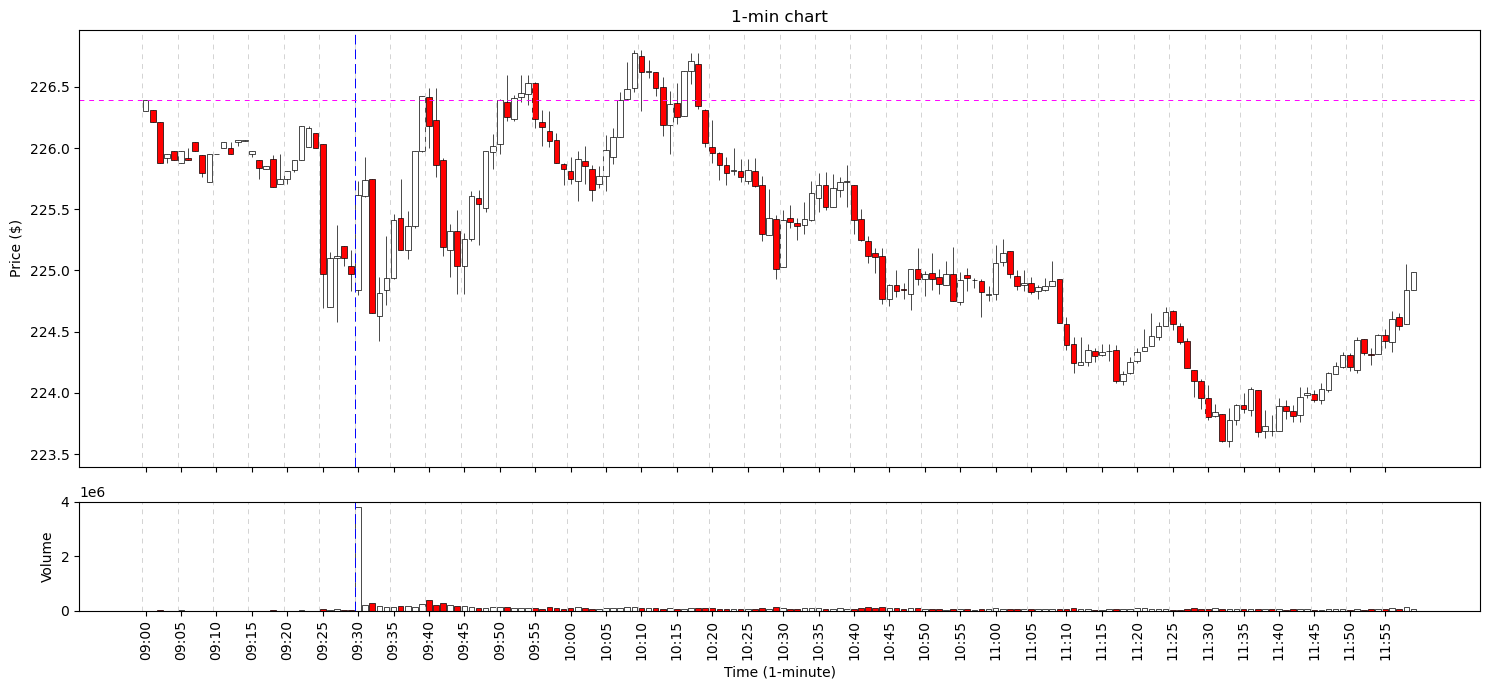

In [61]:
# Function for getting both CS and volume graphs

def get_CS_and_volume_graphs(full_1min_S, green_CS, red_CS, Daily_PM_HL, date_str):
    # Getting the two subplots first
    fig, (CS, Volume) = plt.subplots(2, 1, figsize=(15, 7), sharex=True, height_ratios = [4, 1]);

    # Adding some padding for the CS y-axis to possibly include other technical indicators (like PM high or low) in
    y_min, y_max = full_1min_S['low'].min(), full_1min_S['high'].max()
    padding = (y_max - y_min) / 20
    CS.set_ylim(y_min - padding, y_max + padding) # Plotting only within the ylim with 0.05 extra padding (5% is actually the default, but we need
    # these numbers to make sure we can plot the other lines)
    actual_y_min, actual_y_max = CS.get_ylim() # Getting the new lower and upper y limits

    # Making sure to set the volume ylim from 0 to 1 billion (not the "default" 0, 1) because volume will never reach 1 billion
    volume_y_min, volume_y_max = 0, 1000000000

    # Adding gridlines
    every_5_min_index = full_1min_S.index[::5] - 0.5
    CS.vlines(x = every_5_min_index, ymin = actual_y_min, ymax = actual_y_max, color = 'lightgray', linestyle = (0, (5, 5)), linewidth = 0.7);
    Volume.vlines(x = every_5_min_index, ymin = volume_y_min, ymax = volume_y_max, color = 'lightgray', linestyle = (0, (5, 5)), linewidth = 0.7);

    
    # Adding in high and low wicks in top CS chart
    combined_CS = pd.concat([green_CS, red_CS]).sort_values(by = 'time_str')
    # Previous version for green and red lines
    #plt.vlines(x = combined_CS['time_str'], ymin = combined_CS['low'], ymax = combined_CS['high'],
               #color = ['green' if i in green_CS.index else 'orangered' for i in combined_CS.index], zorder = 1);
    CS.vlines(x = combined_CS['time_str'], ymin = combined_CS['low'], ymax = combined_CS['high'],
               color = 'black', linewidth = 0.5, zorder = 1);
    
    # Getting the green and red bars
    CS.bar(x = green_CS['time_str'], height = green_CS['Height'], bottom = green_CS['open'], color = 'white', edgecolor = 'black', linewidth = 0.5);
    CS.bar(x = red_CS['time_str'], height = red_CS['Height'], bottom = red_CS['close'], color = 'red', edgecolor = 'black', linewidth = 0.5);
    
    # Market open
    combined_time_str = combined_CS['time_str']
    try:
        market_open_index = combined_time_str[combined_time_str == '09:30'].index[0] - combined_time_str.index[0] # .index[0] is used to retrieve
        # the index of the first element of the index array (in case there are more occurrences of 09:30 in the time_str series)
        CS.axvline(x = market_open_index - 0.5, color = 'blue', linestyle = (0, (10, 5)), linewidth = 0.7); # Custom linestyle with offset = 0, and
        # each dash will be 10 units long, followed by a 5-unit gap
        Volume.axvline(x = market_open_index - 0.5, color = 'blue', linestyle = (0, (10, 5)), linewidth = 0.7);
    except:
        pass
    
    # Setting the PM high and lows for the chosen date
    Chosen_date = date_str
    Chosen_dt = pd.to_datetime(Chosen_date).date()
    PM_high_1_day = Daily_PM_HL.loc[Chosen_dt, 'PM_high']
    PM_low_1_day = Daily_PM_HL.loc[Chosen_dt, 'PM_low']
    
    # This would work instead if .reset_index() were used at the end of the Daily_PM_HL variable creation:
    #PM_high_1_day = Daily_PM_HL.loc[Daily_PM_HL['date'] == Chosen_dt, 'PM_high'].values[0]
    
    # Conditionally plotting the horizontal PM high and low lines (if they're within y-axis limits)
    if PM_high_1_day >= actual_y_min and PM_high_1_day <= actual_y_max:
        CS.axhline(PM_high_1_day, color = 'magenta', linestyle = (0, (5, 5)), linewidth = 0.7);
    if PM_low_1_day >= actual_y_min and PM_low_1_day <= actual_y_max:
        CS.axhline(PM_low_1_day, color = 'magenta', linestyle = (0, (5, 5)), linewidth = 0.7);
    
    
    # Adding the volume graph on the bottom
    Volume.bar(x = green_CS['time_str'], height = green_CS['volume'], color = 'white', edgecolor = 'black', linewidth = 0.5);
    Volume.bar(x = red_CS['time_str'], height = red_CS['volume'], color = 'red', edgecolor = 'black', linewidth = 0.5);
    

    # Ticks
    ticks = full_1min_S['time_str'][::5]
    CS.set_xticks(ticks);
    Volume.set_xticks(ticks);
    Volume.set_xticklabels(ticks, rotation = 90);
    #plt.show() # This also works

    # Labels
    Volume.set_xlabel('Time (1-minute)');
    CS.set_ylabel('Price ($)');
    Volume.set_ylabel('Volume');
    CS.set_title('1-min chart');
    
    plt.tight_layout()
    plt.show()

get_CS_and_volume_graphs(AAPL_S, green_CS, red_CS, Daily_PM_HL, Chosen_date)

# Getting highs and lows of day
1. Need to make sure we create lists to store ALL the high and low points - DONE
2. Need to create lists to store the OBVIOUS high and low points (so we don't just replace the new high/low every time)
3. (A bit later): need to write a condition that only defines good opportunities when the HOD/LOD is after awhile (so not just the next CS)

In [63]:
# Function for ceating a new list with only values during the trading day (9:30am - 4:00pm)
def get_trading_day_HL_df(ticker_1_min_df):
    Trading_day_start = pd.to_datetime('09:30:00').time()
    Trading_day_end = pd.to_datetime('16:00:00').time()
    Trading_day_values = ticker_1_min_df[(ticker_1_min_df["time"] >= Trading_day_start) & (ticker_1_min_df["time"] < Trading_day_end)]

    return Trading_day_values

AAPL_trading_day_values = get_trading_day_HL_df(AAPL_1min)

# HOD/LOD dictionaries with only values

In [65]:
# Function for getting every high value by date
def get_HOD_values_dict(Trading_day_minutes_df):
    # Getting high low values by date
    Trading_day_HL = Trading_day_minutes_df.groupby('date') # Grouped object (e.g., Trading_day_HL) behaves like a collection (key, DataFrame) pairs,
    # where key is the value that defines the group (so "date" in this case), and DataFrame is the subset of the original df that belongs to that group
    # (so in this case, all the rows that share the same date)
    HOD_dict = {}
    
    for date, group in Trading_day_HL: # When doing this, each iteration provides the group key (date) and a subset of the original df containing only
    # rows correspond to that date
    
        # Calculate the cumulative maximum (output will be another column in the "group" dataframe)
        group['HOD'] = group['high'].cummax()
    
        new_high_mask = group['high'] >= group['HOD'].shift(1, fill_value=group['high'].iloc[0]) # Creates a mask that compares each row's high value
        # with the previous HOD using .shift(). If the current high is greater than or equal to the previous cum maximum, we record it
        # Btw, iloc[0] just ensures that we get a value in the second slot
            
        HOD_list = group.loc[new_high_mask, 'high'].tolist() # .loc() normally just takes in a row name and column name, but it can also take in a
        # boolean list for the row (in this case, from new_high_mask representing which values took on a new high). This allows .loc() to find only the
        # rows which are labeled as TRUE. Then, it takes only the column called 'high'.
    
        # Storing the HOD_list in a dictionary for the current date
        HOD_dict[date] = HOD_list
        
    return HOD_dict

def get_LOD_values_dict(Trading_day_minutes_df):
    # Getting high low values by date
    Trading_day_HL = Trading_day_minutes_df.groupby('date')
    LOD_dict = {}

    for date, group in Trading_day_HL:
        group['LOD'] = group['low'].cummin()
        new_low_mask = group['low'] <= group['LOD'].shift(1, fill_value=group['low'].iloc[0])
        LOD_list = group.loc[new_low_mask, 'low'].tolist()
        LOD_dict[date] = LOD_list

    return LOD_dict

AAPL_trading_day_values = get_trading_day_HL_df(AAPL_1min)
AAPL_HOD_values_dict = get_HOD_values_dict(AAPL_trading_day_values)
AAPL_LOD_values_dict = get_LOD_values_dict(AAPL_trading_day_values)

# HOD/LOD dictionaries with time and values

In [67]:
# Function for getting every high value by date
def get_HOD_dict(Trading_day_minutes_df):
    # Getting high low values by date
    Trading_day_HL = Trading_day_minutes_df.groupby('date') # Grouped object (e.g., Trading_day_HL) behaves like a collection (key, DataFrame) pairs,
    # where key is the value that defines the group (so "date" in this case), and DataFrame is the subset of the original df that belongs to that group
    # (so in this case, all the rows that share the same date)
    HOD_dict = {}
    
    for date, group in Trading_day_HL: # When doing this, each iteration provides the group key (date) and a subset of the original df containing only
    # rows correspond to that date
    
        # Calculate the cumulative maximum (output will be another column in the "group" dataframe)
        group['HOD'] = group['high'].cummax()
    
        new_high_mask = group['high'] >= group['HOD'].shift(1, fill_value=group['high'].iloc[0]) # Creates a mask that compares each row's high value
        # with the previous HOD using .shift(). If the current high is greater than or equal to the previous cum maximum, we record it
        # Btw, iloc[0] just ensures that we get a value in the second slot
            
        time_high_dict = dict(zip(group.loc[new_high_mask, 'time'], group.loc[new_high_mask, 'high']))
    
        # Storing the time_high_dict in another dictionary for the current date
        HOD_dict[date] = time_high_dict
        
    return HOD_dict

def get_LOD_dict(Trading_day_minutes_df):
    # Getting high low values by date
    Trading_day_HL = Trading_day_minutes_df.groupby('date')
    LOD_dict = {}

    for date, group in Trading_day_HL:
        group['LOD'] = group['low'].cummin()
        new_low_mask = group['low'] <= group['LOD'].shift(1, fill_value=group['low'].iloc[0])
        time_low_dict = dict(zip(group.loc[new_low_mask, 'time'], group.loc[new_low_mask, 'low']))
        LOD_dict[date] = time_low_dict

    return LOD_dict

AAPL_HOD_dict = get_HOD_dict(AAPL_trading_day_values)
AAPL_LOD_dict = get_LOD_dict(AAPL_trading_day_values)

In [68]:
AAPL_HOD_dict

{datetime.date(2024, 7, 15): {datetime.time(9, 30): 236.78,
  datetime.time(9, 32): 237.23},
 datetime.date(2024, 7, 16): {datetime.time(9, 30): 235.35,
  datetime.time(9, 31): 235.46,
  datetime.time(9, 32): 235.752,
  datetime.time(9, 34): 236.26,
  datetime.time(9, 35): 236.27},
 datetime.date(2024, 7, 17): {datetime.time(9, 30): 230.185,
  datetime.time(9, 31): 230.7999,
  datetime.time(9, 32): 231.06,
  datetime.time(9, 33): 231.17,
  datetime.time(9, 34): 231.4599},
 datetime.date(2024, 7, 18): {datetime.time(9, 30): 230.44,
  datetime.time(9, 39): 230.44},
 datetime.date(2024, 7, 19): {datetime.time(9, 30): 225.73,
  datetime.time(9, 31): 225.93,
  datetime.time(9, 38): 225.98,
  datetime.time(9, 39): 226.425,
  datetime.time(9, 40): 226.49,
  datetime.time(9, 41): 226.49,
  datetime.time(9, 51): 226.6,
  datetime.time(9, 53): 226.6,
  datetime.time(9, 54): 226.6,
  datetime.time(10, 8): 226.7,
  datetime.time(10, 9): 226.8,
  datetime.time(10, 10): 226.8},
 datetime.date(2024, 